# Attacks on the Yeast protein interaction network

## Task

Using NetworkX, load the Yeast protein interaction network (file datasets/bio-yeast-protein-inter/bio-yeast-protein-inter.edges), remove self-loop edges, and consider the largest connected component. Then, implement the following network attack strategy (random walk attack): (4 points)

1. Select the first node at random and remove it,
2. Select a node at random among the neighbors of the previously removed node, and
remove it,
3. After each node removal, remove all the isolated nodes from the network,
4. Repeat step 2. and 3. until all nodes are removed.

In case the set of neighbors is empty at step 2., select a random neighbor of a randomly
chosen node to be removed.
Compare the effectiveness of the above attack strategy against:

(a) Random attack,

(b) Attack targeting nodes based on their degree (from higher degree to lower degree, as
seen in class),

(c) Same as point c., but targeting nodes in reverse order (i.e., from lower degree nodes to
higher degree nodes)

Comment briefly which attack disrupt the network faster and try to give an argument on
why the random walk attack is more/less/as effective as the attack of point (b).
Load the network using the following code:
```G = nx.read_edgelist(file_path, create_using=nx.Graph)```
Note that you can use the NetworkX functions to find self-loop edges and isolated nodes

In [1]:
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import sys

print("Python version (might be important for orchestrating the packages): "+ sys.version)
print("NetworkX version: ", nx.__version__)
print("Numpy version: ", np.__version__)
print("Scipy version: ", scipy.__version__)
print("Pandas version: ", pd.__version__)
print("Seaborn version: ", sns.__version__)
print("Matplotlib version: ", plt.matplotlib.__version__)

Python version (might be important for orchestrating the packages): 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
NetworkX version:  3.3
Numpy version:  1.26.4
Scipy version:  1.13.1
Pandas version:  2.1.1
Seaborn version:  0.13.1
Matplotlib version:  3.9.2


Load the graph

In [2]:
file_path = "./datasets/bio-yeast-protein-inter/bio-yeast-protein-inter.edges"
G = nx.read_edgelist(file_path, create_using=nx.Graph)

### Remove self-loop edges, and consider the largest connected component

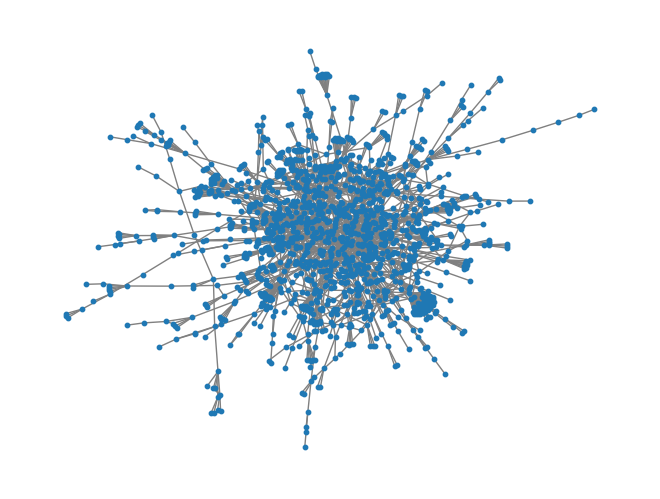

In [3]:
self_loop_edges = [(x,y) for (x,y) in list(G.edges()) if x == y]
G.remove_edges_from(self_loop_edges)
components = list(nx.connected_components(G))
G_lcc_nodes= sorted(components, key = lambda x: len(x)) [-1] # We sort the components by size, the last one is the biggest
G = G.subgraph(G_lcc_nodes)

nx.draw(G, node_size=10, edge_color='gray', with_labels=False)

It's visible that there are quite some hubs. This information will be useful later.

### Attack implementations

Let's modify the run_attack_simulation function example from class 4 to implement the random walk attack strategy.

We can implement the different attacks as functions. The random_attack function will have an extra input (`nodes_to_choose_from`), which for random attack is actually always equal to the set of all nodes; but to make the implementation of the random walk attack easier, I added it as an input; for random walk attacks, this set will be the set of neighbors of the last removed node. 

In [4]:
def run_attack_simulation(G, attack_function, seed=None):
    """
    Simulate the removal of nodes from a graph according to a given attack type and compute the relative size of the largest connected component.

    Parameters
    ----------
    G : nx.Graph
        The input graph.
    attack_function : function
        The function for the type of attack to perform. Either "random_attack", "highest_degree_attack", "lowest_degree_attack", or "random_walk_attack".
    seed : int or np.random.RandomState, optional
        The random seed to use. If None, a new random state is created. If int, the random state is initialized with the given seed. If np.random.RandomState, the given random state is used. Default is None.

    Returns
    -------
    size_largest_cc : list
        The relative size of the largest connected component at each step.
    """

    #Seed
    if seed is None:
        RNG = np.random.RandomState()
    elif type(seed) is int:
        RNG = np.random.RandomState(seed)
    elif type(seed) is np.random.RandomState:
        RNG = seed
    else:
        raise ValueError("Unknown seed type")

    G_attack = G.copy()
    size_largest_cc_init = len(max(nx.connected_components(G_attack), key=len))

    #Attack
    size_largest_cc = []
    for i in range(G_attack.number_of_nodes() - 1): #Repeating Step 2 and 3 until the network is empty (Step 4)
        #Select node to remove, remove it and compute the size of the largest connected component

        if attack_function in [random_attack, highest_degree_attack, lowest_degree_attack]:
            node_attack = attack_function(G_attack, RNG)
        elif attack_function == random_walk_attack:
            if i == 0:
                neighbors_of_last_node = list(G_attack.nodes()) #Step 1: Select the first node at random and remove it
            node_attack = random_walk_attack(G_attack, RNG, neighbors_of_last_node)
            neighbors_of_last_node = list(G_attack.neighbors(node_attack))
        else:
            raise ValueError(f"Unknown attack function: {attack_function}")
        
        G_attack.remove_node(node_attack)
        if attack_function == random_walk_attack:
            #Step 3: After each node removal, remove all the isolated nodes from the network
            nodes_to_remove = list(nx.isolates(G_attack))
            G_attack.remove_nodes_from(nodes_to_remove)
            neighbors_of_last_node = [x for x in neighbors_of_last_node if x not in nodes_to_remove] #Remove these from the list of neighbors

        if G_attack.number_of_nodes() == 0:
            break
        size_lcc_ = len(max(nx.connected_components(G_attack), key=len))
        size_largest_cc.append(size_lcc_/size_largest_cc_init)
        

    return size_largest_cc

def random_attack(G, RNG=None, nodes_to_choose_from=None):
    """
    Perform a random attack on a graph. (Typically, all nodes are given to be choosen from, unless the random walk attack is used under the hood.)

    Parameters
    ----------
    G : nx.Graph
        The input graph.
    RNG : np.random.RandomState or None
        The random seed to use. If None, a new random state is created. If np.random.RandomState, the given random state is used. Default is None.
        
    Returns
    -------
    size_largest_cc : list
        The relative size of the largest connected component at each step.
    """
    if RNG is None:
        RNG = np.random.RandomState()
    if nodes_to_choose_from is None:
        nodes_to_choose_from = list(G.nodes())
    
    node_attack = RNG.choice(nodes_to_choose_from)
    return node_attack

def highest_degree_attack(G, RNG=None):
    """
    Perform a highest degree attack on a graph.

    Parameters
    ----------
    G : nx.Graph
        The input graph.
    RNG : np.random.RandomState or None
        The random seed to use. If None, a new random state is created. If np.random.RandomState, the given random state is used. Default is None.
    Returns
    -------
    size_largest_cc : list
        The relative size of the largest connected component at each step.
    """
    if RNG is None:
        RNG = np.random.RandomState()
    
    node_attack = max(G.degree(), key=lambda item: item[1])[0]
    return node_attack

def lowest_degree_attack(G, RNG=None):
    """
    Perform a lowest degree attack on a graph.

    Parameters
    ----------
    G : nx.Graph
        The input graph.
    RNG : np.random.RandomState or None
        The random seed to use. If None, a new random state is created. If np.random.RandomState, the given random state is used. Default is None.
    Returns
    -------
    size_largest_cc : list
        The relative size of the largest connected component at each step.
    """
    if RNG is None:
        RNG = np.random.RandomState()
    
    node_attack = min(G.degree(), key=lambda item: item[1])[0]
    return node_attack

def random_walk_attack(G, RNG=None, nodes_to_choose_from=None):
    #For the current description, it's simpler to just use the random_attack function
    if RNG is None:
        RNG = np.random.RandomState()
    
    iters = 0
    if nodes_to_choose_from is None:
        nodes_to_choose_from = list(G.nodes())
    while len(nodes_to_choose_from)==0 and iters < 100:
        #In case the set of neighbors is empty at step 2., select a random neighbor of a randomly chosen node to be removed.
        node_attack = RNG.choice(list(G.nodes()))
        nodes_to_choose_from = list(G.neighbors(node_attack))
        iters += 1

    if iters == 100:
        return random_attack(G, RNG) #Choose a random node to remove, all nodes seem to have no neighbors (graph will be empty).
    return random_attack(G, RNG, nodes_to_choose_from) #Step 2: Select a random neighbor of the last node to be removed and remove it.

### Plot the results

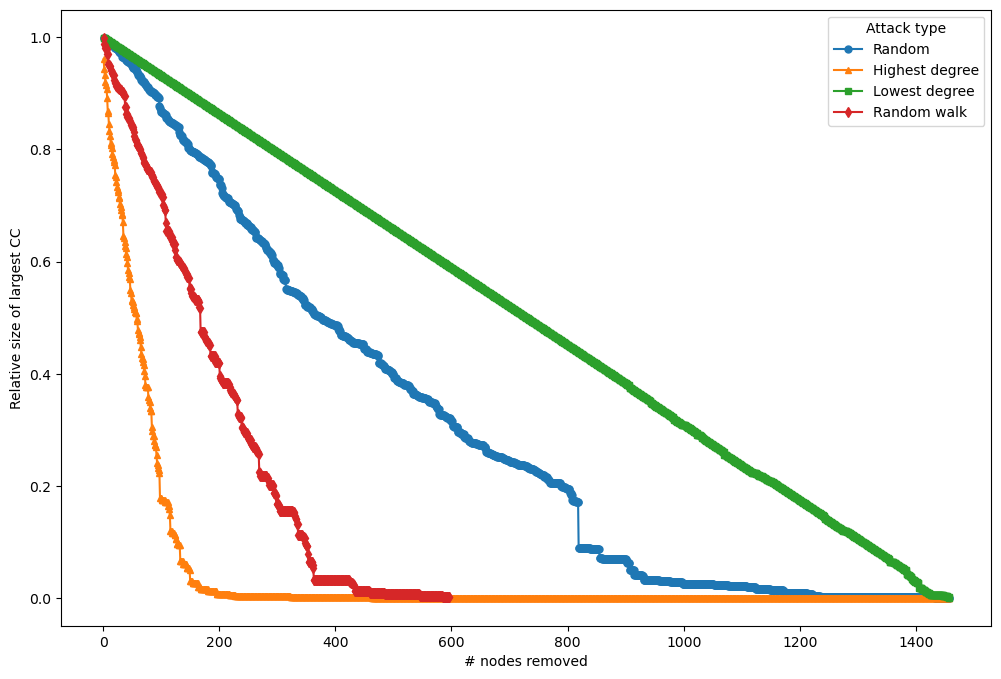

In [5]:
# run the simulations
size_largest_cc_random = run_attack_simulation(G, attack_function=random_attack, seed=42)
size_largest_cc_degree = run_attack_simulation(G, attack_function=highest_degree_attack, seed=42)
size_largest_cc_lowest_degree = run_attack_simulation(G, attack_function=lowest_degree_attack, seed=42)
size_largest_cc_random_walk = run_attack_simulation(G, attack_function=random_walk_attack, seed=42)

# plot the results
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(range(1, len(size_largest_cc_random)+1), size_largest_cc_random, "o-", markersize=5, label="Random")
ax.plot(range(1, len(size_largest_cc_degree)+1), size_largest_cc_degree, "^-", markersize=5, label="Highest degree")
ax.plot(range(1, len(size_largest_cc_lowest_degree)+1), size_largest_cc_lowest_degree, "s-", markersize=5, label="Lowest degree")
ax.plot(range(1, len(size_largest_cc_random_walk)+1), size_largest_cc_random_walk, "d-", markersize=5, label="Random walk")

ax.set_xlabel("# nodes removed")
ax.set_ylabel("Relative size of largest CC")

ax.legend(title="Attack type");

### Comparison of the attack strategies

As we see from the plot, the attacks in strength order:

High degree > Random walk > Random > Low degree

The highest degree node attack is the most effective attack strategy. This is because hubs are often around high degree nodes, and removing these nodes will disrupt the hubs and the network more effectively. With a similar argument, the lowest degree node attack is the least effective attack strategy. Often, just leaf nodes are removed, which do not disrupt the network.<br>
The random attack is in between the highest and lowest degree node attack. Due to randomness, high degree nodes aren't immediately targeted - however by chance they are sooner removed than in the lowest degree node attack.

How does the random walk attack compare?<br>
It is more effective than the random attack: it targets the neighbors of the removed nodes, which artificially increases the chance for targeting high degree nodes. The chance for being selected as a node in a random attack is $\frac{1}{N}$, whereas for a node with degree $k$ the possibility is rather $\frac{1}{N}\sum_{(k_i,k)\in E} \frac{1}{k_i}$. The more neighbors a node has, the bigger the sum, therefore more often high degree nodes are chosen.<br>
In fact, we can also argue on this using the Friendship paradox. The average degree of a neighbor of a node is higher than the degree of the node itself, i.e. the neighbors of selected nodes typically have higher degree, and choosing from them thus on average increases the chance of choosing a higher degree node.

We said that there seem to be many separate hubs. Because the nature of the random walk, if it enters a hub's "territory" (set of nodes nearby), it tends to stay around it as the hubs have many nodes connected to them (depending on the type of network, the hub might even have a high clustering coefficient and neighbours are well-connected) - it might take more than expected steps to get to a different side of the network from it. There is a co-developing procedure: easier to get into the nearby cluster of a hub, harder to get away from it. This is positive against the random attack, as hubs are more effectively targeted, but negative against highest degree node attack, as that switches immediately to other hubs with a "jump" (the highest degree one in fact).